# 1. Environment Setup
In this section, we install the necessary dependencies. We specifically install `PyMaxflow` for the GraphCut algorithm and pin `numpy` to version 1.26.4 to ensure compatibility with the library.

In [1]:
# Install required packages
!pip install kagglehub nibabel
!pip install PyMaxflow==1.2.15

# Downgrade numpy to version 1.26.4 to avoid compatibility issues
!pip uninstall -y numpy
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires num

# 2. Imports & Configuration
In this section, we import the standard libraries for file handling (`os`), numerical operations (`numpy`), medical image processing (`nibabel`), and visualization (`matplotlib`). We also configure the plotting style.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import kagglehub
from google.colab import drive

# Configure matplotlib for inline plotting and set default figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)

# 3. Data Acquisition
We mount Google Drive to access or save files if necessary, and then download the **LiTS (Liver Tumor Segmentation)** dataset using the `kagglehub` library.

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Download the dataset
path = kagglehub.dataset_download("javariatahir/litstrain-val")
print("Path to dataset files:", path)

Resuming download from 7540310016 bytes (9253496384 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/javariatahir/litstrain-val?dataset_version_number=1 (7540310016/16793806400) bytes left.


100%|██████████| 15.6G/15.6G [01:30<00:00, 102MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1


In [4]:
for root, dirs, files in os.walk(path):
    for f in files[:10]:
        print(os.path.join(root, f))

/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)/test_mask/segmentation-114.nii
/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)/test_mask/segmentation-122.nii
/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)/test_mask/segmentation-123.nii
/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)/test_mask/segmentation-126.nii
/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)/test_mask/segmentation-117.nii
/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)/test_mask/segmentation-115.nii
/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)/test_mask/segmentation-111.nii
/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)/test_mask/segmentation-113.nii
/root/.cache/kagglehub/datasets/javariatahir/litstrain-v

# 4. Data Loading & Visualization
In this section, we load a sample CT volume (`volume-119`) and its corresponding segmentation mask to verify the data integrity. We then visualize the middle slice to ensure the CT scan and the Ground Truth (GT) mask are correctly aligned.

/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)/test_CT/volume-119.nii
CT shape: (512, 512, 461)
Seg shape: (512, 512, 461)


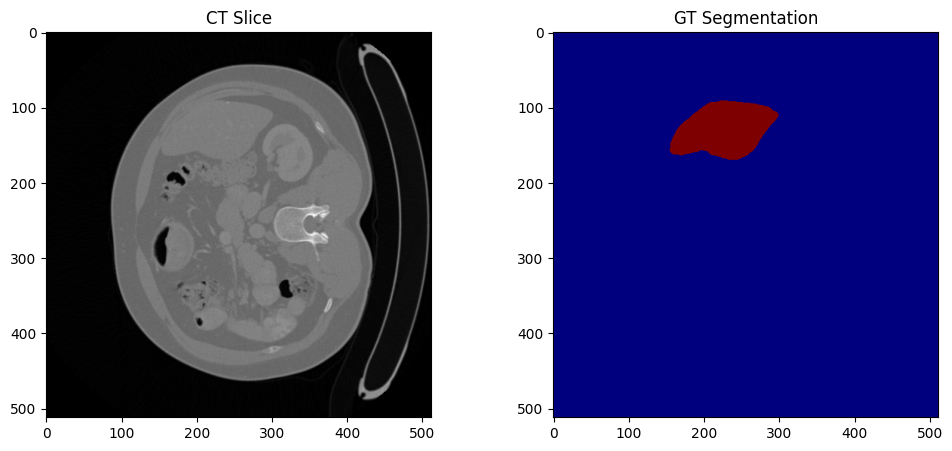

In [7]:
# Define paths to a specific test volume and its segmentation
# Note: These paths are based on the LiTS dataset structure downloaded in the previous step
volume_path = os.path.join(path, "LiTS(train_test)/test_CT/volume-119.nii")
seg_path = os.path.join(path, "LiTS(train_test)/test_mask/segmentation-119.nii")

# Load the NIfTI files
print(f"Loading volume: {os.path.basename(volume_path)}")
ct_nii = nib.load(volume_path)
seg_nii = nib.load(seg_path)

# Convert to numpy arrays
ct_volume = ct_nii.get_fdata()
gt_seg = seg_nii.get_fdata()

print(f"CT Volume Shape: {ct_volume.shape}")
print(f"Segmentation Shape: {gt_seg.shape}")

# Visualize the middle slice
slice_idx = ct_volume.shape[2] // 2

plt.figure(figsize=(10, 5))

# Plot CT Image
plt.subplot(1, 2, 1)
plt.imshow(ct_volume[:, :, slice_idx], cmap='gray')
plt.title(f"CT Slice (Index: {slice_idx})")
plt.axis('off')

# Plot Ground Truth Mask
plt.subplot(1, 2, 2)
plt.imshow(gt_seg[:, :, slice_idx], cmap='jet', alpha=0.7) # Alpha makes it slightly transparent
plt.title(f"Ground Truth Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

# 5. Data Preprocessing
In this section, we define utility functions to preprocess the CT volumes. This typically involves **intensity windowing** (clipping values to a specific range, e.g., for liver tissue) and **min-max normalization** to scale the data between 0 and 1. We also prepare the masks.

In [ ]:
def preprocess_volume(volume, min_hu=-100, max_hu=400):
    """
    Clips the CT volume to the specified HU range and normalizes it to [0, 1].
    """
    # Clip intensity values
    volume = np.clip(volume, min_hu, max_hu)
    
    # Normalize to [0, 1]
    volume = (volume - min_hu) / (max_hu - min_hu)
    return volume.astype(np.float32)

def preprocess_mask(mask):
    """
    Processes the ground truth mask. 
    LiTS Dataset: 0 = Background, 1 = Liver, 2 = Tumor.
    We convert this to a binary mask (1 for Liver+Tumor, 0 for Background) for this task.
    """
    # Create binary mask: Foreground (Liver + Tumor) = 1
    binary_mask = (mask > 0).astype(np.float32)
    return binary_mask

# Apply preprocessing to the sample loaded earlier
ct_processed = preprocess_volume(ct_volume)
seg_processed = preprocess_mask(gt_seg)

print(f"Processed CT Range: [{ct_processed.min():.2f}, {ct_processed.max():.2f}]")
print(f"Processed Mask Unique Values: {np.unique(seg_processed)}")

# 6. Model Definition (U-Net)
We define the U-Net architecture, a widely used convolutional neural network for biomedical image segmentation. It consists of an **encoder (contracting path)** to capture context and a **decoder (expanding path)** to enable precise localization.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class EnhancedUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        # Output
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder path with skip connections
        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)

        logits = self.outc(x)
        return logits

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=1, n_classes=2).to(device)
print("Model initialized on:", device)

# 7. U-Net Inference & Visualization
This section defines the `run_inference` function. It performs the following steps:
1.  Loads a specific CT slice and its mask.
2.  Preprocesses the image (windowing, normalizing, resizing) to match the model's training requirements.
3.  Runs the U-Net model to generate a coarse prediction.
4.  Visualizes the Original CT, Ground Truth, and Model Prediction side-by-side.
5.  Returns the resized image and prediction for further processing (GraphCut).

Running inference on: cuda


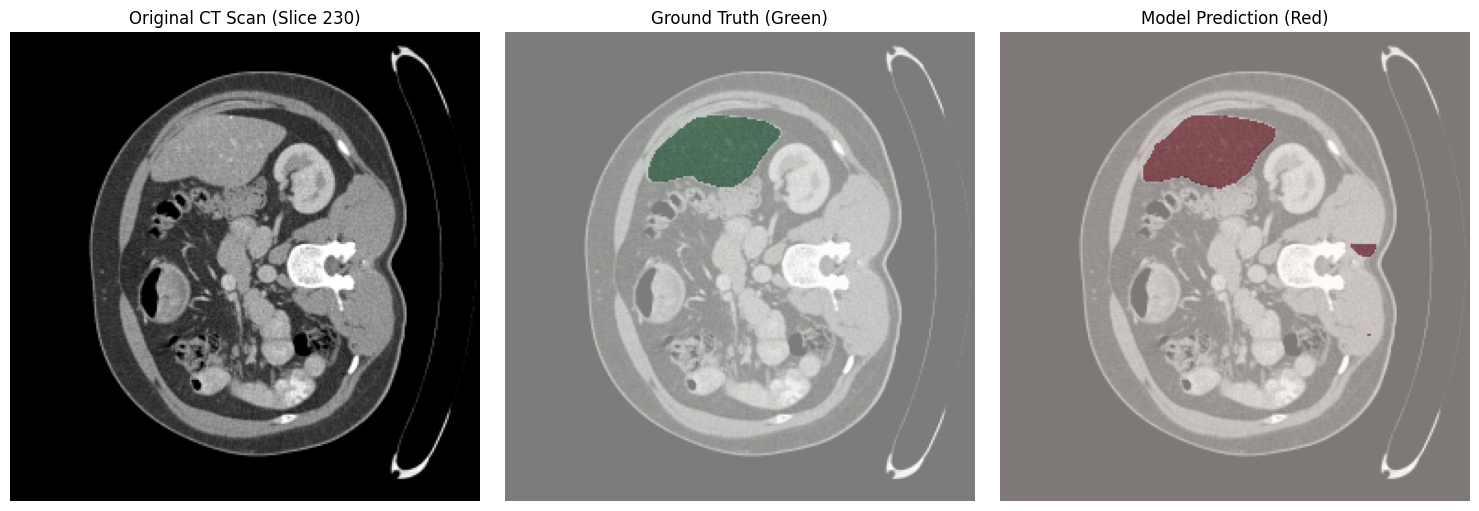

In [9]:
import cv2  # Required for resizing

def run_inference(img_path, mask_path, slice_idx, model_path):
    """
    Loads the trained model, performs inference on a single CT slice,
    and plots the original image, ground truth, and model prediction.
    """
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running inference on: {device}")

    # Initialize the model 
    # NOTE: Ensure 'EnhancedUNet' matches the class name defined in Section 6
    model = EnhancedUNet(in_channels=1, out_channels=1).to(device)
    
    # Load weights
    checkpoint = torch.load(model_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    model.eval()

    # Load image and ground truth mask data
    img_obj = nib.load(img_path)
    mask_obj = nib.load(mask_path)
    
    img_data = img_obj.dataobj[:, :, slice_idx]
    mask_data = mask_obj.dataobj[:, :, slice_idx]

    # Preprocessing: Windowing (-200 to 250 HU) and Normalization
    img_clipped = np.clip(img_data, -200, 250)
    img_norm = (img_clipped - (-200)) / 450.0
    
    # Resize to model input size (256x256)
    img_resized = cv2.resize(img_norm, (256, 256), interpolation=cv2.INTER_AREA)

    # Prepare binary ground truth mask
    true_mask = cv2.resize((mask_data > 0).astype(np.float32), (256, 256), interpolation=cv2.INTER_NEAREST)

    # Convert to PyTorch tensor: (Batch, Channel, Height, Width)
    img_tensor = torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output_logit = model(img_tensor)
        pred_prob = torch.sigmoid(output_logit).squeeze().cpu().numpy()
        pred_mask = (pred_prob > 0.5).astype(np.uint8)

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Original CT
    axes[0].imshow(img_resized, cmap='gray')
    axes[0].set_title(f'Original CT Scan (Slice {slice_idx})')
    axes[0].axis('off')

    # Plot 2: Ground Truth
    axes[1].imshow(img_resized, cmap='gray')
    axes[1].imshow(true_mask, cmap='Greens', alpha=0.5)
    axes[1].set_title('Ground Truth (Green)')
    axes[1].axis('off')

    # Plot 3: Model Prediction
    axes[2].imshow(img_resized, cmap='gray')
    axes[2].imshow(pred_mask, cmap='Reds', alpha=0.5)
    axes[2].set_title('U-Net Prediction (Red)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Return items needed for GraphCut
    bg_mask = 1 - pred_mask
    return img_resized, pred_mask, bg_mask

# --- Example Usage ---
# Ensure 'volume_path' and 'seg_path' from Section 4 are defined.
# Update 'model_path' to point to your .pth file.
# 
# img_resized, pred_mask, bg_mask = run_inference(
#     img_path=volume_path,
#     mask_path=seg_path,
#     slice_idx=slice_idx,
#     model_path='/content/drive/MyDrive/Colab Notebooks/parham_model.pth'
# )

# 8. Dynamic Data Loading
In this section, we dynamically search for all CT volumes and segmentation masks in the downloaded directory. We also load the first pair found to verify the data dimensions.

In [26]:
# Base directory where dataset was extracted
base_path = "/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)"

# Dynamically find all volume and segmentation .nii files
# Using recursive=True to search through all subdirectories (volume-pt1, pt2, etc.)
volume_paths = sorted(glob.glob(os.path.join(base_path, '**', 'volume-*.nii'), recursive=True))
mask_paths = sorted(glob.glob(os.path.join(base_path, '**', 'segmentation-*.nii'), recursive=True))

print(f"Total CT volumes found: {len(volume_paths)}")
print(f"Total segmentation masks found: {len(mask_paths)}")

# Load the first volume and mask to check their dimensions
if len(volume_paths) > 0 and len(mask_paths) > 0:
    print("Loading sample volume to check shapes (this might take a few seconds)...")
    sample_vol = nib.load(volume_paths[0]).get_fdata()
    sample_mask = nib.load(mask_paths[0]).get_fdata()

    print(f"Sample Volume Shape: {sample_vol.shape}")
    print(f"Sample Mask Shape: {sample_mask.shape}")
else:
    print("Error: Could not find the .nii files. Please check the extraction path.")

Total CT volumes found: 131
Total segmentation masks found: 131
Loading sample volume to check shapes (this might take a few seconds)...
Sample Volume Shape: (512, 512, 761)
Sample Mask Shape: (512, 512, 761)


## 9. Again : PyTorch Dataset & DataLoader
We define a custom `LiTSDataset` class to handle the medical data. This class:
1.  **Pairs** volumes with their correct segmentation masks.
2.  **Scans** the dataset to filter out empty slices (containing no liver/tumor) to optimize training.
3.  **Preprocesses** slices on-the-fly (windowing, normalizing, resizing).
4.  **Splits** the data into training and validation sets.

In [29]:
import os
import cv2
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# --- Configuration ---
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16

# --- 1. Match Volumes and Masks ---
valid_volumes = []
valid_masks = []

for vol_path in volume_paths:
    vol_name = os.path.basename(vol_path)
    # Extract ID (e.g., 'volume-119.nii' -> '119')
    vol_num = vol_name.replace('volume-', '').replace('.nii', '')

    # Find the matching segmentation file
    mask_path = next((m for m in mask_paths if f'segmentation-{vol_num}.nii' in m), None)
    
    if mask_path:
        valid_volumes.append(vol_path)
        valid_masks.append(mask_path)

# --- 2. Train/Validation Split ---
# We split at the volume level to prevent data leakage (slices from the same patient shouldn't be in both sets)
train_vol, val_vol, train_mask, val_mask = train_test_split(
    valid_volumes, valid_masks, test_size=0.2, random_state=42
)

# --- 3. Dataset Class Definition ---
class LiTSDataset(Dataset):
    def __init__(self, vol_paths, mask_paths):
        self.vol_paths = vol_paths
        self.mask_paths = mask_paths
        self.slices_info = []

        print(f"Scanning {len(vol_paths)} volumes for valid slices... (This takes a moment)")
        
        # Pre-scan volumes to find slices containing liver tissue (labels > 0)
        for v_path, m_path in zip(vol_paths, mask_paths):
            try:
                # Load mask to check content
                mask_data = nib.load(m_path).get_fdata()
                # Identify z-indices where mask is not empty (sum > 0)
                valid_z = np.where(np.sum(mask_data, axis=(0, 1)) > 0)[0]
                
                for z in valid_z:
                    self.slices_info.append((v_path, m_path, z))
            except Exception as e:
                print(f"Skipping {m_path}: {e}")

        print(f"Found {len(self.slices_info)} valid slices with liver tissue.")

    def __len__(self):
        return len(self.slices_info)

    def __getitem__(self, idx):
        v_path, m_path, z = self.slices_info[idx]

        # Use dataobj for lazy loading (reads only the specific slice from disk)
        img_slice = nib.load(v_path).dataobj[:, :, z]
        mask_slice = nib.load(m_path).dataobj[:, :, z]

        # 1. Windowing (Clip to -200 to 250 HU for soft tissue contrast)
        img_clipped = np.clip(img_slice, -200, 250)

        # 2. Min-Max Normalization to [0, 1]
        img_norm = (img_clipped - (-200)) / (250 - (-200))

        # 3. Resizing
        img_resized = cv2.resize(img_norm, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
        mask_resized = cv2.resize(mask_slice, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)

        # 4. Binarize Mask (Liver+Tumor=1, Background=0)
        mask_binary = (mask_resized > 0).astype(np.float32)

        # 5. Convert to PyTorch Tensors (Channel, Height, Width)
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(mask_binary, dtype=torch.float32).unsqueeze(0)

        return img_tensor, mask_tensor

# --- 4. Initialize Loaders ---
# (Currently initializing Validation only, as per your code)
val_dataset = LiTSDataset(val_vol, val_mask)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- 5. Verify Shapes ---
sample_images, sample_masks = next(iter(val_loader))
print(f"PyTorch Image Batch Shape: {sample_images.shape}")
print(f"PyTorch Mask Batch Shape: {sample_masks.shape}")

Scanning 27 volumes for valid slices... (This takes a moment)
Found 4191 valid slices with liver tissue.
PyTorch Image Batch Shape: torch.Size([16, 1, 256, 256])
PyTorch Mask Batch Shape: torch.Size([16, 1, 256, 256])


## 9. Quantitative Evaluation
In this section, we define metrics (**Dice Score** and **Pixel Accuracy**) and run a full evaluation on the validation set (`val_loader`). This allows us to assess the model's performance on unseen data.

* **Dice Score:** Measures the overlap between the prediction and the ground truth (1.0 is perfect overlap).
* **Pixel Accuracy:** Measures the percentage of pixels correctly classified.

In [30]:
import torch
import numpy as np

def dice_score(pred, target, eps=1e-7):
    """
    Computes the Dice Score for a batch.
    Args:
        pred, target: torch tensors of shape (B, 1, H, W) with {0, 1} values.
    Returns:
        dice: per-sample dice score, shape (B,).
    """
    pred = pred.float()
    target = target.float()

    # Flatten per-sample (Batch, Pixels)
    pred_f = pred.view(pred.size(0), -1)
    targ_f = target.view(target.size(0), -1)

    intersection = (pred_f * targ_f).sum(dim=1)
    union = pred_f.sum(dim=1) + targ_f.sum(dim=1)

    dice = (2.0 * intersection + eps) / (union + eps)
    return dice

def pixel_accuracy(pred, target):
    """
    Computes the Pixel Accuracy for a batch.
    Args:
        pred, target: torch tensors of shape (B, 1, H, W) with {0, 1} values.
    Returns:
        acc: per-sample accuracy, shape (B,).
    """
    correct = (pred == target).float()
    # Mean across all pixels in the image
    acc = correct.view(correct.size(0), -1).mean(dim=1)
    return acc

def evaluate_on_val_loader(val_loader, model_path, threshold=0.5):
    """
    Loads the model and evaluates it on the entire validation loader.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Evaluating on: {device}")

    # Initialize model
    # NOTE: 'EnhancedUNet' class must be defined in a previous cell!
    model = EnhancedUNet(in_channels=1, out_channels=1).to(device)
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    model.eval()

    all_dice = []
    all_acc = []

    print("Starting evaluation loop...")
    with torch.no_grad():
        for batch_idx, (imgs, masks) in enumerate(val_loader):
            imgs = imgs.to(device)          # Shape: (B, 1, H, W)
            masks = masks.to(device)        # Shape: (B, 1, H, W)

            # Forward pass
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()

            # Ensure masks are binary {0, 1}
            gt = (masks > 0.5).float()

            # Calculate metrics
            dice_b = dice_score(preds, gt)      # Shape: (B,)
            acc_b  = pixel_accuracy(preds, gt)  # Shape: (B,)

            all_dice.append(dice_b.cpu())
            all_acc.append(acc_b.cpu())

            # Print progress every 10 batches
            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(val_loader):
                print(f"Batch {batch_idx+1}/{len(val_loader)} "
                      f"| Dice: {dice_b.mean().item():.4f} "
                      f"| Acc: {acc_b.mean().item():.4f}")

    # Concatenate results
    all_dice = torch.cat(all_dice).numpy()
    all_acc  = torch.cat(all_acc).numpy()

    print("\n==== Validation Results ====")
    print(f"Mean Dice: {all_dice.mean():.4f}  (std: {all_dice.std():.4f})")
    print(f"Mean Acc : {all_acc.mean():.4f}  (std: {all_acc.std():.4f})")

    return all_dice, all_acc

# --- Run Evaluation ---
# Make sure to update the path to your actual .pth model file
dice_vals, acc_vals = evaluate_on_val_loader(
    val_loader=val_loader,
    model_path="/content/drive/MyDrive/Colab Notebooks/parham_model.pth",
    threshold=0.5
)

Evaluating on: cuda
Batch 10/262 | Dice: 0.9856 | Acc: 0.9995
Batch 20/262 | Dice: 0.8414 | Acc: 0.9919
Batch 30/262 | Dice: 0.6820 | Acc: 0.9279
Batch 40/262 | Dice: 0.8284 | Acc: 0.9709
Batch 50/262 | Dice: 0.9617 | Acc: 0.9988
Batch 60/262 | Dice: 0.9586 | Acc: 0.9844
Batch 70/262 | Dice: 0.6871 | Acc: 0.9954
Batch 80/262 | Dice: 0.3695 | Acc: 0.8852
Batch 90/262 | Dice: 0.9449 | Acc: 0.9939
Batch 100/262 | Dice: 0.8876 | Acc: 0.9764
Batch 110/262 | Dice: 0.9155 | Acc: 0.9830
Batch 120/262 | Dice: 0.9711 | Acc: 0.9987
Batch 130/262 | Dice: 0.9601 | Acc: 0.9995
Batch 140/262 | Dice: 0.2967 | Acc: 0.9688
Batch 150/262 | Dice: 0.9457 | Acc: 0.9993
Batch 160/262 | Dice: 0.5455 | Acc: 0.9904
Batch 170/262 | Dice: 0.9578 | Acc: 0.9902
Batch 180/262 | Dice: 0.9244 | Acc: 0.9756
Batch 190/262 | Dice: 0.8789 | Acc: 0.9577
Batch 200/262 | Dice: 0.7776 | Acc: 0.9985
Batch 210/262 | Dice: 0.9817 | Acc: 0.9991
Batch 220/262 | Dice: 0.9296 | Acc: 0.9966
Batch 230/262 | Dice: 0.8715 | Acc: 0.9928


# 10. Advanced GraphCut (GrabCut-Style) Implementation
In this section, we implement a more robust GraphCut algorithm inspired by **GrabCut**. 

Unlike simple GraphCut which uses fixed intensity histograms, this version:
1.  **Iteratively learns** the appearance of Foreground (Liver/Tumor) and Background using **Gaussian Mixture Models (GMMs)**.
2.  **Extracts multiple features** per pixel: Intensity, Smoothed Intensity, Gradient Magnitude, and Spatial Coordinates (x, y).
3.  **Supports arbitrary seed shapes** (rectangles, polygons, scribbles) rather than just hard constraints.

In [10]:
import numpy as np
import maxflow
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import nibabel as nib
from scipy import ndimage as ndi
from matplotlib.path import Path


# ============================================================
# 1. Seed mask utilities (ARBITRARY SHAPES)
# ============================================================

def seed_mask_from_rect(shape, rect):
    """
    Creates a boolean mask from a rectangle.
    rect = (x1, y1, x2, y2) where x2, y2 are exclusive.
    """
    m, n = shape
    x1, y1, x2, y2 = rect
    mask = np.zeros((m, n), dtype=bool)
    mask[y1:y2, x1:x2] = True
    return mask


def seed_mask_from_polygon(shape, vertices_xy):
    """
    Fill a polygon given by vertices [(x,y), ...] into a boolean mask.
    Works for arbitrary shapes (not only rectangles).
    """
    m, n = shape
    poly = Path(np.asarray(vertices_xy, dtype=np.float64))

    xs, ys = np.meshgrid(np.arange(n), np.arange(m))
    pts = np.column_stack([xs.ravel(), ys.ravel()])
    inside = poly.contains_points(pts).reshape(m, n)
    return inside


def seed_mask_from_scribble_points(shape, points_xy, radius=3):
    """
    Create a seed mask from a set of scribble points by stamping disks.
    points_xy: iterable of (x,y)
    """
    m, n = shape
    mask = np.zeros((m, n), dtype=bool)
    rr = int(radius)

    for (x, y) in points_xy:
        x = int(round(x))
        y = int(round(y))
        y0, y1 = max(0, y - rr), min(m, y + rr + 1)
        x0, x1 = max(0, x - rr), min(n, x + rr + 1)
        yy, xx = np.ogrid[y0:y1, x0:x1]
        disk = (yy - y)**2 + (xx - x)**2 <= rr ** 2
        mask[y0:y1, x0:x1] |= disk

    return mask


# ============================================================
# 2. Feature extraction (more informative than intensity-only)
# ============================================================

def compute_features(I, spatial_weight=0.25, smooth_sigma=1.0):
    """
    Build a per-pixel feature vector:
      [HU, HU_smooth, gradmag, spatial_x, spatial_y]
    """
    I = I.astype(np.float64)
    m, n = I.shape

    Is = ndi.gaussian_filter(I, smooth_sigma)

    gx = ndi.sobel(Is, axis=1)
    gy = ndi.sobel(Is, axis=0)
    grad = np.hypot(gx, gy)

    xs, ys = np.meshgrid(np.arange(n), np.arange(m))
    x = (xs - (n - 1) / 2.0) / max(n, 1)
    y = (ys - (m - 1) / 2.0) / max(m, 1)

    F = np.stack([I, Is, grad, spatial_weight * x, spatial_weight * y], axis=-1)
    return F


def robust_normalize_features(F, roi_mask=None):
    """
    Robust normalize each feature dimension using median and IQR.
    """
    m, n, d = F.shape
    X = F.reshape(-1, d)

    if roi_mask is None:
        Xr = X
    else:
        Xr = X[roi_mask.ravel()]

    med = np.median(Xr, axis=0)
    q75 = np.percentile(Xr, 75, axis=0)
    q25 = np.percentile(Xr, 25, axis=0)
    iqr = (q75 - q25)
    iqr[iqr < 1e-8] = 1.0

    Xn = (X - med) / iqr
    return Xn.reshape(m, n, d)


# ============================================================
# 3. Pairwise term scaling (GrabCut-style beta)
# ============================================================

def grabcut_beta(I):
    I = I.astype(np.float64)
    diffs = []
    diffs.append((I[:, 1:] - I[:, :-1]) ** 2)
    diffs.append((I[1:, :] - I[:-1, :]) ** 2)
    diffs.append((I[1:, 1:] - I[:-1, :-1]) ** 2)
    diffs.append((I[1:, :-1] - I[:-1, 1:]) ** 2)
    mean_diff_sq = np.mean([d.mean() for d in diffs])
    return 1.0 / (2.0 * mean_diff_sq + 1e-12)


def fit_gmm(X, n_components=5, reg_covar=1e-3, random_state=42):
    """
    Fit a GMM robustly; reduce components if too few points.
    X: (N, D)
    """
    X = np.asarray(X, dtype=np.float64)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    N = X.shape[0]
    if N < 5:
        k = 1
    else:
        k = min(n_components, max(1, N // 50))

    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        reg_covar=reg_covar,
        random_state=random_state,
        max_iter=200,
        init_params="kmeans",
    )
    gmm.fit(X)
    return gmm


# ============================================================
# 4. Main: iterative GrabCut-like GraphCut WITH ARBITRARY SEEDS
# ============================================================

def graph_cut_iterative(
    slice_img,
    fg_seed_mask,                 # <-- arbitrary shape mask (bool)
    bg_seed_mask,                 # <-- arbitrary shape mask (bool)
    k=30.0,                       # smoothness scale (gamma)
    iterations=5,
    n_components=5,
    fg_prior=0.05,                # tumor small
    hard_seeds=True,
    seed_inf=1e9,
    spatial_weight=0.25,          # how much x,y help (0 disables)
    distance_bias=0.0,            # try 0.0..2.0 if needed
    restrict_to_body=True,        # helps reduce air/background confusion
    body_threshold_hu=-500,       # air is ~ -1000 HU
    keep_component_touching_fg=True,
    verbose=True,
):
    """
    Output segmentation:
      0 = background
      1 = foreground
    """
    I = np.asarray(slice_img, dtype=np.float64)
    m, n = I.shape

    fg_seed_mask = np.asarray(fg_seed_mask, dtype=bool)
    bg_seed_mask = np.asarray(bg_seed_mask, dtype=bool)

    if fg_seed_mask.shape != (m, n) or bg_seed_mask.shape != (m, n):
        raise ValueError("Seed masks must have same shape as slice_img.")

    if np.any(fg_seed_mask & bg_seed_mask):
        raise ValueError("FG and BG seeds overlap.")

    if fg_seed_mask.sum() == 0 or bg_seed_mask.sum() == 0:
        raise ValueError("Both FG and BG seed masks must contain at least 1 pixel.")

    # --- ROI mask (optional but usually helps) ---
    roi_mask = None
    if restrict_to_body:
        # crude "body" mask: everything above air threshold, then keep largest CC
        body = I > body_threshold_hu
        lab, num = ndi.label(body)
        if num > 0:
            sizes = ndi.sum(body, lab, index=np.arange(1, num + 1))
            largest = 1 + int(np.argmax(sizes))
            roi_mask = (lab == largest)
        else:
            roi_mask = body

        # ensure seeds are within ROI; if not, expand ROI to include them
        roi_mask = roi_mask | fg_seed_mask | bg_seed_mask

    # --- features for better unary term (not just intensity) ---
    F = compute_features(I, spatial_weight=spatial_weight, smooth_sigma=1.0)
    F = robust_normalize_features(F, roi_mask=roi_mask)
    d = F.shape[-1]

    # initial segmentation: FG where FG seeds, BG otherwise (within ROI)
    seg = np.zeros((m, n), dtype=np.uint8)
    seg[fg_seed_mask] = 1
    seg[bg_seed_mask] = 0

    beta = grabcut_beta(I)
    neighbors = [(0, 1, 1.0), (1, 0, 1.0), (1, 1, np.sqrt(2.0)), (1, -1, np.sqrt(2.0))]

    eps = 1e-6
    fg_prior = float(np.clip(fg_prior, eps, 1.0 - eps))
    log_pi_f = np.log(fg_prior)
    log_pi_b = np.log(1.0 - fg_prior)

    # precompute distance maps if using distance bias
    if distance_bias > 0:
        dist_fg = ndi.distance_transform_edt(~fg_seed_mask)
        dist_bg = ndi.distance_transform_edt(~bg_seed_mask)
        dist_fg = dist_fg / (dist_fg.max() + 1e-8)
        dist_bg = dist_bg / (dist_bg.max() + 1e-8)

    for it in range(iterations):
        # ------------------------------------------------------------
        # Fit GMMs on current FG/BG (plus seeds)
        # ------------------------------------------------------------
        fg_train = (seg == 1) | fg_seed_mask
        bg_train = (seg == 0) | bg_seed_mask

        if roi_mask is not None:
            fg_train &= roi_mask
            bg_train &= roi_mask

        Xf = F[fg_train].reshape(-1, d)
        Xb = F[bg_train].reshape(-1, d)

        gmm_f = fit_gmm(Xf, n_components=n_components, reg_covar=1e-3)
        gmm_b = fit_gmm(Xb, n_components=n_components, reg_covar=1e-3)

        # ------------------------------------------------------------
        # Unary costs
        # Df = cost for FG, Db = cost for BG
        # ------------------------------------------------------------
        Xall = F.reshape(-1, d)
        ll_f = gmm_f.score_samples(Xall)
        ll_b = gmm_b.score_samples(Xall)

        Df = -(ll_f + log_pi_f).reshape(m, n)
        Db = -(ll_b + log_pi_b).reshape(m, n)

        # optional distance bias for spatial coherence around seeds
        if distance_bias > 0:
            Df = Df + distance_bias * dist_fg
            Db = Db + distance_bias * dist_bg

        # shift to non-negative
        off = min(Df.min(), Db.min())
        Df = np.maximum(Df - off, 0.0)
        Db = np.maximum(Db - off, 0.0)

        if verbose:
            print(f"[iter {it+1}/{iterations}] Df: {Df.min():.3f}..{Df.max():.3f} | "
                  f"Db: {Db.min():.3f}..{Db.max():.3f}")

        # ------------------------------------------------------------
        # Build graph
        # ------------------------------------------------------------
        g = maxflow.Graph[float]()
        g.add_nodes(m * n)

        def node_id(i, j):
            return i * n + j

        # Add T-links (Data term)
        # We iterate carefully to handle ROI masking and hard seeds
        # Note: Ideally vectorized, but explicit loop handles the logic clearly
        
        # Flattened arrays for vectorized graph construction (optimization opportunity)
        # But keeping the loop for clarity as per your original code structure
        
        for i in range(m):
            base = i * n
            for j in range(n):
                idx = base + j

                # If using ROI, force outside ROI to background
                if roi_mask is not None and (not roi_mask[i, j]):
                    g.add_tedge(idx, float(seed_inf), 0.0)  # force BG
                    continue

                if hard_seeds and fg_seed_mask[i, j]:
                    g.add_tedge(idx, 0.0, float(seed_inf))  # force FG
                elif hard_seeds and bg_seed_mask[i, j]:
                    g.add_tedge(idx, float(seed_inf), 0.0)  # force BG
                else:
                    g.add_tedge(idx, float(Df[i, j]), float(Db[i, j]))

                # Add N-links (Smoothness term)
                Ip = I[i, j]
                for di, dj, dist in neighbors:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < m and 0 <= nj < n:
                        if roi_mask is not None and (not roi_mask[ni, nj]):
                            continue
                        diff = Ip - I[ni, nj]
                        w = (k / dist) * np.exp(-beta * (diff * diff))
                        if w > 0:
                            g.add_edge(idx, node_id(ni, nj), float(w), float(w))

        flow = g.maxflow()
        if verbose:
            print(f"[iter {it+1}/{iterations}] maxflow: {flow:.3f}")

        new_seg = np.zeros((m, n), dtype=np.uint8)
        for i in range(m):
            base = i * n
            for j in range(n):
                new_seg[i, j] = g.get_segment(base + j)  # 0=BG(source), 1=FG(sink)

        # keep only components that touch FG seeds (reduces scattered false positives)
        if keep_component_touching_fg:
            fg = (new_seg == 1)
            lab, num = ndi.label(fg)
            if num > 0:
                touching = np.unique(lab[fg_seed_mask & (lab > 0)])
                if touching.size > 0:
                    fg = np.isin(lab, touching)
                    new_seg = fg.astype(np.uint8)

        seg = new_seg

    return seg


# ============================================================
# 5. Visualization + Dice (optional)
# ============================================================

def visualize(slice_img, seg, fg_seed_mask=None, bg_seed_mask=None, title="GraphCut"):
    I = np.asarray(slice_img, dtype=np.float64)
    vis = (I - I.min()) / (I.max() - I.min() + 1e-8)
    vis = (vis * 255).astype(np.uint8)

    out = np.stack([vis, vis, vis], axis=-1).astype(np.float32)
    alpha = 0.45
    fg = seg == 1
    bg = seg == 0

    # red FG
    out[fg, 0] = (1 - alpha) * out[fg, 0] + alpha * 255
    out[fg, 1] *= (1 - alpha)
    out[fg, 2] *= (1 - alpha)

    # blue BG
    out[bg, 2] = (1 - alpha) * out[bg, 2] + alpha * 255
    out[bg, 0] *= (1 - alpha)
    out[bg, 1] *= (1 - alpha)

    out = np.clip(out, 0, 255).astype(np.uint8)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(vis, cmap="gray")
    ax[0].set_title("Input")
    ax[0].axis("off")

    ax[1].imshow(seg, cmap="gray", vmin=0, vmax=1)
    ax[1].set_title("Mask (0=BG, 1=FG)")
    ax[1].axis("off")

    ax[2].imshow(out)
    if fg_seed_mask is not None:
        ax[2].contour(fg_seed_mask.astype(np.uint8), levels=[0.5], colors="lime", linewidths=1)
    if bg_seed_mask is not None:
        ax[2].contour(bg_seed_mask.astype(np.uint8), levels=[0.5], colors="red", linewidths=1)
    ax[2].set_title(title + " (overlay; seeds outlined)")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()


def dice(a, b):
    a = a.astype(bool)
    b = b.astype(bool)
    inter = np.logical_and(a, b).sum()
    return (2.0 * inter) / (a.sum() + b.sum() + 1e-8)

# 11. GraphCut Refinement: Execution & Visualization
In this section, we apply the `graph_cut_iterative` function to refine the U-Net's prediction. We use the U-Net's foreground and background masks as the initial seeds. We then visualize the final refined segmentation alongside the original image and seed boundaries to evaluate the improvement.

In [11]:
# --- 1. Run Iterative GraphCut Refinement ---
# We use the resized image and the masks generated in Section 7 (Inference)
seg_refined = graph_cut_iterative(
    img_resized,
    pred_mask.astype(bool),         # Foreground seed from U-Net
    bg_mask.astype(bool),           # Background seed from U-Net
    k=30.0,                         # Smoothness scale
    iterations=5,                   # Number of GMM update cycles
    n_components=5,                 # Number of GMM components
    fg_prior=0.05,                  # Prior probability of foreground
    hard_seeds=True,                # Constrain seeds to their initial labels
    seed_inf=1e9,                   # Penalty for violating hard seeds
    spatial_weight=0.25,            # Influence of (x, y) coordinates
    distance_bias=0.0,              # Spatial distance penalty
    restrict_to_body=True,          # Ignore air/background outside the body
    body_threshold_hu=-500,         # HU threshold for air
    keep_component_touching_fg=True,# Clean up disconnected false positives
    verbose=True
)


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f6eeb7b2f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


[iter 1/5] Df: 1.371..409.778 | Db: 0.000..29.367
[iter 1/5] maxflow: 8208.172
[iter 2/5] Df: 1.371..409.778 | Db: 0.000..29.367
[iter 2/5] maxflow: 8208.172
[iter 3/5] Df: 1.371..409.778 | Db: 0.000..29.367
[iter 3/5] maxflow: 8208.172
[iter 4/5] Df: 1.371..409.778 | Db: 0.000..29.367
[iter 4/5] maxflow: 8208.172
[iter 5/5] Df: 1.371..409.778 | Db: 0.000..29.367
[iter 5/5] maxflow: 8208.172


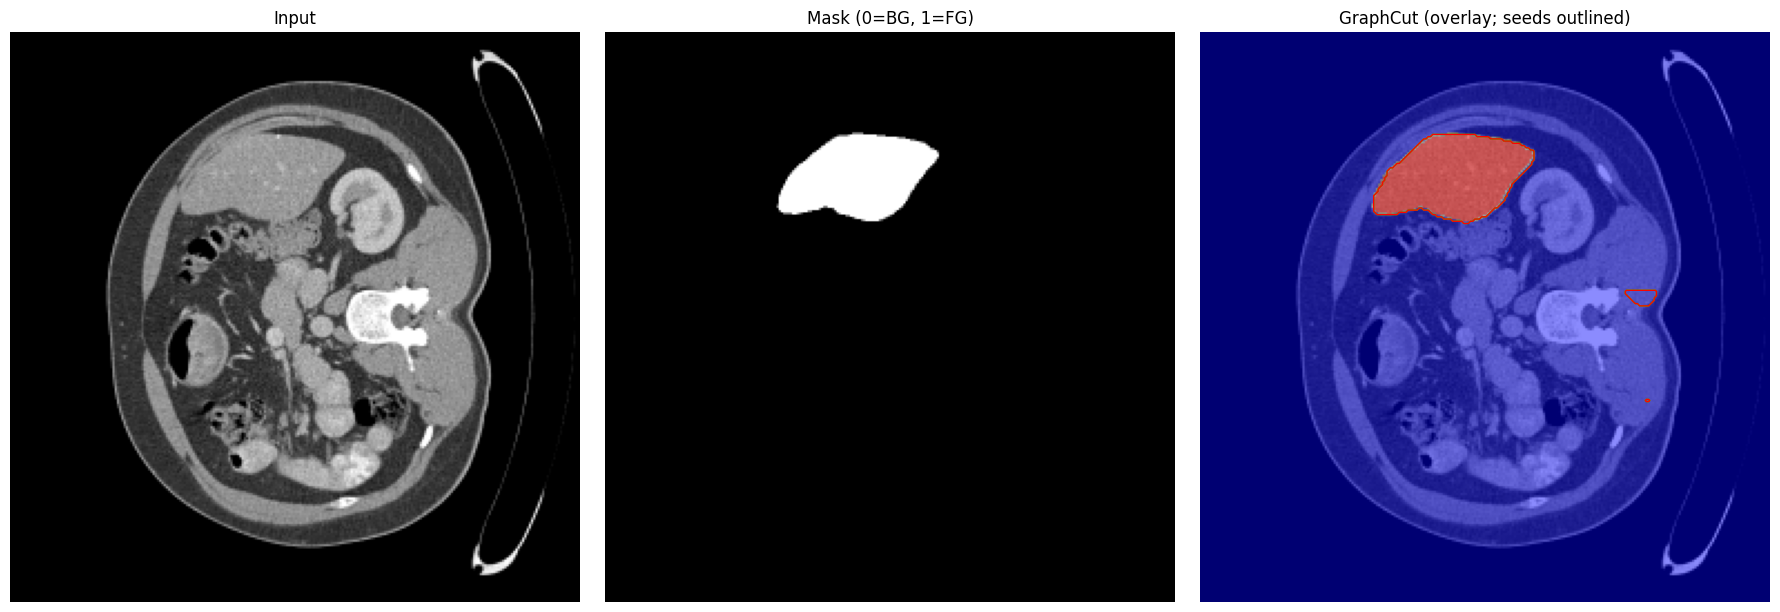

In [12]:
# --- 2. Prepare Ground Truth for Comparison ---
# Resize the original ground truth mask to match the 256x256 inference size
gt_seg_img = cv2.resize(gt_seg[:, :, slice_idx], (256, 256), interpolation=cv2.INTER_NEAREST)

# --- 3. Visualize Results ---
# This displays the Input, the Refined Mask, and an Overlay with seed outlines
visualize(
    img_resized, 
    seg_refined, 
    fg_seed_mask=pred_mask, 
    bg_seed_mask=bg_mask, 
    title="Refined GraphCut Segmentation"
)

# --- 4. Calculate Refinement Dice ---
initial_dice = dice(pred_mask, gt_seg_img)
refined_dice = dice(seg_refined, gt_seg_img)

print(f"\nInitial U-Net Dice: {initial_dice:.4f}")
print(f"Refined GraphCut Dice: {refined_dice:.4f}")

# 12. Comparison & Benchmarking: U-Net vs. GraphCut
In this final section, we perform a side-by-side comparison of the raw U-Net predictions and the GraphCut-refined results. 

Key features of this evaluation:
1.  **Sparse Seeding:** We use binary erosion to shrink the U-Net's prediction into a "confident interior" seed, allowing the GraphCut to redefine the edges based on image gradients.
2.  **Performance Metrics:** We calculate Dice Score and Pixel Accuracy for both methods.
3.  **Efficiency Benchmarking:** We track the time taken for a standard GPU forward pass (U-Net) vs. the iterative GraphCut process to highlight the trade-off between accuracy and speed.

In [32]:
import time
import numpy as np


# ---- 1. Metrics (Numpy Implementation) ----
def dice_np(pred, gt, eps=1e-8):
    """Computes Dice Score for numpy arrays."""
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    return (2.0 * inter + eps) / (pred.sum() + gt.sum() + eps)

def acc_np(pred, gt):
    """Computes Pixel Accuracy for numpy arrays."""
    return (pred == gt).mean()

# ---- 2. Morphological Utilities for Sparse Seeds ----
def erode_mask(mask01, k=5, iters=1):
    """Binary erosion on {0,1} mask using OpenCV."""
    mask01 = (mask01 > 0).astype(np.uint8)
    kernel = np.ones((k, k), np.uint8)
    return cv2.erode(mask01, kernel, iterations=iters)

def dilate_mask(mask01, k=5, iters=1):
    """Binary dilation on {0,1} mask using OpenCV."""
    mask01 = (mask01 > 0).astype(np.uint8)
    kernel = np.ones((k, k), np.uint8)
    return cv2.dilate(mask01, kernel, iterations=iters)

# ---- 3. Main Evaluation Loop ----
@torch.no_grad()
def eval_unet_vs_graphcut(
    val_loader,
    model_path,
    slices_per_batch=2,          # Number of samples per batch to run GraphCut on (slow)
    max_batches=20,              # Cap total batches to save time
    threshold=0.5,
    use_sparse_seeds=True,       # If True, erodes UNet output to create seeds
    fg_erode_k=7,
    fg_erode_iters=1,
    bg_erode_k=7,
    bg_erode_iters=1,
    graphcut_kwargs=None,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # Load model
    model = EnhancedUNet(in_channels=1, out_channels=1).to(device)
    ckpt = torch.load(model_path, map_location=device)
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        model.load_state_dict(ckpt["model_state_dict"])
    else:
        model.load_state_dict(ckpt)
    model.eval()

    if graphcut_kwargs is None:
        graphcut_kwargs = dict(
            k=30.0,
            iterations=5,
            n_components=5,
            fg_prior=0.05,
            hard_seeds=True,
            seed_inf=1e9,
            spatial_weight=0.25,
            distance_bias=0.0,
            restrict_to_body=True,
            body_threshold_hu=-500,
            keep_component_touching_fg=True,
            verbose=False, # Set to False for cleaner batch output
        )

    # Accumulators for results
    unet_dices, unet_accs = [], []
    gc_dices, gc_accs = [], []
    t_unet, t_gc = 0.0, 0.0

    rng = np.random.default_rng(42)
    num_batches = len(val_loader)
    batches_to_run = min(num_batches, max_batches)

    for b_idx, (imgs, masks) in enumerate(val_loader):
        if b_idx >= batches_to_run:
            break

        imgs = imgs.to(device)
        masks = masks.to(device)

        # UNet forward pass (timed)
        t0 = time.time()
        logits = model(imgs)
        probs = torch.sigmoid(logits)
        preds = (probs > threshold).float()
        t_unet += (time.time() - t0)

        # Select random samples from the batch for GraphCut
        B = imgs.shape[0]
        take = min(slices_per_batch, B)
        sel = rng.choice(B, size=take, replace=False)

        for i in sel:
            pred_i = preds[i, 0].detach().cpu().numpy().astype(np.uint8)
            gt_i   = (masks[i, 0] > 0.5).detach().cpu().numpy().astype(np.uint8)

            unet_dices.append(dice_np(pred_i, gt_i))
            unet_accs.append(acc_np(pred_i, gt_i))

            # Build seeds for GraphCut
            if use_sparse_seeds:
                # FG seeds: interior of predicted liver
                fg_seed = erode_mask(pred_i, k=fg_erode_k, iters=fg_erode_iters).astype(bool)
                # BG seeds: interior of predicted background
                bg_seed = erode_mask(1 - pred_i, k=bg_erode_k, iters=bg_erode_iters).astype(bool)

                # Fallback: if erosion wipes out everything, use original masks
                if fg_seed.sum() == 0: fg_seed = pred_i.astype(bool)
                if bg_seed.sum() == 0: bg_seed = (1 - pred_i).astype(bool)
            else:
                fg_seed = pred_i.astype(bool)
                bg_seed = (1 - pred_i).astype(bool)

            # Invert normalization to restore HU-like scale for GraphCut
            img01 = imgs[i, 0].detach().cpu().numpy()
            img_hu_like = img01 * 450.0 - 200.0

            # Run GraphCut refinement (timed)
            t1 = time.time()
            seg_gc = graph_cut_iterative(
                img_hu_like,
                fg_seed_mask=fg_seed,
                bg_seed_mask=bg_seed,
                **graphcut_kwargs
            )
            t_gc += (time.time() - t1)

            seg_gc = seg_gc.astype(np.uint8)
            gc_dices.append(dice_np(seg_gc, gt_i))
            gc_accs.append(acc_np(seg_gc, gt_i))

        if (b_idx + 1) % 5 == 0 or (b_idx + 1) == batches_to_run:
            print(f"Batch {b_idx+1}/{batches_to_run} | "
                  f"UNet Dice {np.mean(unet_dices):.4f} Acc {np.mean(unet_accs):.4f} | "
                  f"GC Dice {np.mean(gc_dices):.4f} Acc {np.mean(gc_accs):.4f}")

    # Summary Statistics
    print("\n===== SUMMARY (sampled slices only) =====")
    print(f"Samples evaluated: {len(unet_dices)}")
    print(f"UNet  : Dice {np.mean(unet_dices):.4f} ± {np.std(unet_dices):.4f} | Acc {np.mean(unet_accs):.4f} ± {np.std(unet_accs):.4f}")
    print(f"GraphC: Dice {np.mean(gc_dices):.4f} ± {np.std(gc_dices):.4f} | Acc {np.mean(gc_accs):.4f} ± {np.std(gc_accs):.4f}")
    print(f"\nTiming: UNet forward {t_unet:.2f}s | GraphCut total {t_gc:.2f}s")
    if len(unet_dices) > 0:
        print(f"Avg per-slice GraphCut time: {t_gc / len(unet_dices):.3f}s")

    return {
        "unet_dice_mean": float(np.mean(unet_dices)),
        "gc_dice_mean": float(np.mean(gc_dices)),
        "t_gc_sec": float(t_gc)
    }

# ---- Execution ----
results = eval_unet_vs_graphcut(
    val_loader=val_loader,
    model_path="/content/drive/MyDrive/Colab Notebooks/parham_model.pth",
    slices_per_batch=2,
    max_batches=20,
    threshold=0.5,
    use_sparse_seeds=True,
)

Device: cuda
[iter 1/5] Df: 2.785..2344.456 | Db: 0.000..25.442
[iter 1/5] maxflow: 1927.343
[iter 2/5] Df: 3.101..1770.140 | Db: 0.000..26.137
[iter 2/5] maxflow: 1872.091
[iter 3/5] Df: 2.255..1773.884 | Db: 0.000..21.113
[iter 3/5] maxflow: 1753.918
[iter 4/5] Df: 0.565..1792.764 | Db: 0.000..19.123
[iter 4/5] maxflow: 1441.928
[iter 5/5] Df: 3.474..1805.658 | Db: 0.000..25.466
[iter 5/5] maxflow: 1859.320
[iter 1/5] Df: 0.399..2826.406 | Db: 0.000..25.184
[iter 1/5] maxflow: 16026.083
[iter 2/5] Df: 0.608..2649.585 | Db: 0.000..21.840
[iter 2/5] maxflow: 16147.188
[iter 3/5] Df: 0.000..2334.304 | Db: 0.391..26.236
[iter 3/5] maxflow: 15537.673
[iter 4/5] Df: 0.000..2334.304 | Db: 0.391..26.236
[iter 4/5] maxflow: 15537.673
[iter 5/5] Df: 0.000..2334.304 | Db: 0.391..26.236
[iter 5/5] maxflow: 15537.673
[iter 1/5] Df: 1.198..2988.269 | Db: 0.000..47.283
[iter 1/5] maxflow: 22720.211
[iter 2/5] Df: 1.378..889.652 | Db: 0.000..32.707
[iter 2/5] maxflow: 21768.726
[iter 3/5] Df: 1.454.

{'unet_dice_mean': 0.9533387497028707,
 'unet_acc_mean': 0.9943756103515625,
 'gc_dice_mean': 0.9401264855370528,
 'gc_acc_mean': 0.9928070068359375,
 'n_samples': 40,
 't_unet_sec': 0.13847923278808594,
 't_gc_sec': 944.2994821071625}